In [2]:
import pandas as pd

feature_name_df = pd.read_csv('./datasets/human_activity/features.txt',sep='\s+',
           header=None,names=['column_index','column_name'])

In [8]:
# feature명 만 리스트 객체로 생성된 뒤 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
feature_name[:10]

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X']

In [13]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [14]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name'] =new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) if x[1] >0 else x[0],axis=1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [15]:
def get_human_dataset():
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./datasets/human_activity/features.txt',sep='\s+',
           header=None,names=['column_index','column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df를 이용 신규 피쳐명 df생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DF에 피쳐명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터 셋을 DF로 로딩 컬러명은 feature_name적용
    x_train = pd.read_csv('./datasets/human_activity/train/X_train.txt',sep="\s+",names=feature_name)
    x_test = pd.read_csv('./datasets/human_activity/test/X_test.txt',sep="\s+",names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DF로 할당 컬럼명은 action으로 부여
    y_train = pd.read_csv('./datasets/human_activity/train/y_train.txt',sep="\s+",header=None,names=['action'])
    y_test = pd.read_csv('./datasets/human_activity/test/y_test.txt',sep="\s+",header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 변환
    return x_train,x_test,y_train,y_test

x_train,x_test,y_train,y_test=get_human_dataset()

In [18]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [21]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [36]:
##### 의사결정 나무
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train,y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test,pred)
print(f'트리 예측 정확도: {accuracy}')
print(f'기본 하이퍼파라미터 {dt_clf.get_params()}')

트리 예측 정확도: 0.8547675602307431
기본 하이퍼파라미터 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


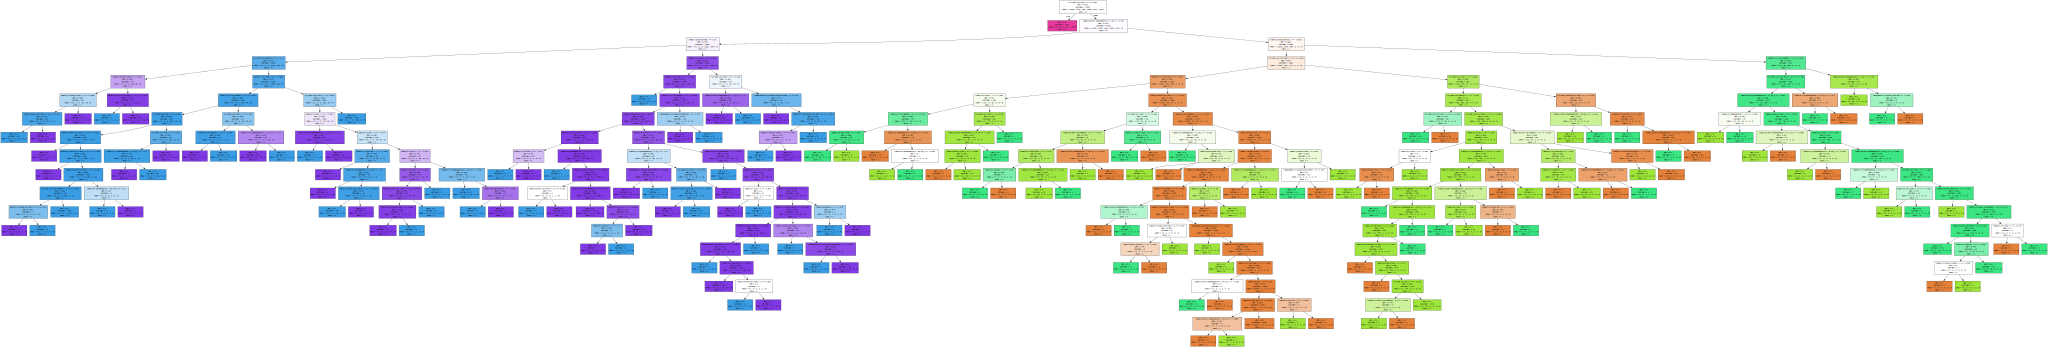

In [43]:
#시각화
from sklearn.tree import export_graphviz
import graphviz

# export_graohviz() 호출결과로 out_file로 지정된 tree.dot파일 생성
export_graphviz(dt_clf,out_file="human.dot",class_names=['1','2','3','4','5','6'],
               feature_names=x_train.columns,impurity=True,filled=True)

# 위에서 생성된 tree.dot파일을 graphviz 읽어서 jupter notebook상에서 시각화
with open("human.dot") as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render(filename='humanity_img', directory='./', format='png')
graph


In [32]:
## 하이퍼파라미터 gridsearch
param = {'max_depth':[6,8,10,12,16,20,24]}

grid_cv = GridSearchCV(dt_clf,param_grid=param,cv=5,scoring='accuracy',verbose=1)
grid_cv.fit(x_train,y_train)
print(f'최적의 max_depth: {grid_cv.best_params_}')
print(f'교차검증 평균 정확도 {grid_cv.best_score_}')

Fitting 5 folds for each of 7 candidates, totalling 35 fits
최적의 max_depth: {'max_depth': 16}
교차검증 평균 정확도 0.8513444970102249


In [37]:
## 최적의 하이퍼파라미터 max_depth=16을 이용하여 test데이터 평가
best_dt = grid_cv.best_estimator_
pred = best_dt.predict(x_test)
accuracy = accuracy_score(y_test,pred)
print(f'트리 예측 정확도: {accuracy}')

트리 예측 정확도: 0.8574821852731591


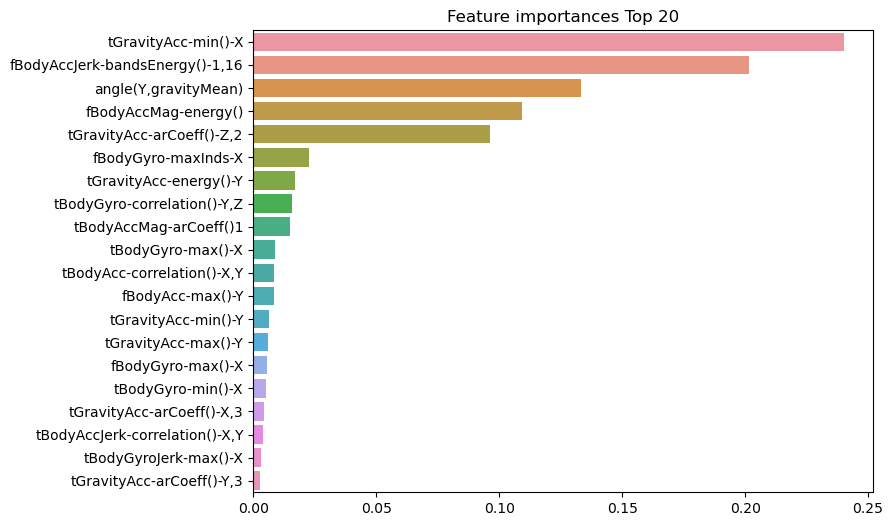

In [47]:
###  변수의 중요도 시각화
import seaborn as sns
import matplotlib.pyplot as plt

ftf_importances_values = best_dt.feature_importances_
importances = pd.Series(ftf_importances_values,index=x_train.columns)
top20 = importances.sort_values(ascending=False)[:20]

### 
plt.figure(figsize=(8,6))
plt.title("Feature importances Top 20")
sns.barplot(x=top20,y=top20.index)
plt.show()

In [45]:
top20

tGravityAcc-min()-X                0.240128
fBodyAccJerk-bandsEnergy()-1,16    0.201486
angle(Y,gravityMean)               0.133057
fBodyAccMag-energy()               0.109450
tGravityAcc-arCoeff()-Z,2          0.096247
fBodyGyro-maxInds-X                0.022719
tGravityAcc-energy()-Y             0.016840
tBodyGyro-correlation()-Y,Z        0.015651
tBodyAccMag-arCoeff()1             0.015083
tBodyGyro-max()-X                  0.008671
tBodyAcc-correlation()-X,Y         0.008382
fBodyAcc-max()-Y                   0.008364
tGravityAcc-min()-Y                0.006296
tGravityAcc-max()-Y                0.005962
fBodyGyro-max()-X                  0.005630
tBodyGyro-min()-X                  0.005188
tGravityAcc-arCoeff()-X,3          0.004503
tBodyAccJerk-correlation()-X,Y     0.003760
tBodyGyroJerk-max()-X              0.003290
tGravityAcc-arCoeff()-Y,3          0.002867
dtype: float64